# Investigate 2019 Traffic Count Data

Date: Jan 21, 2020

In [150]:
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
atlasdir = "S:/AdminGroups/PerformanceProgramming/RegionalTransportationPerformanceMeasures/KeyDatasets/IDOTExpresswayAtlasData/2019/"

### set up to render interactive plot in downloaded html 
Source: https://github.com/altair-viz/altair/issues/329#issuecomment-397827342

In [167]:
import json  # need it for json.dumps
from altair.vega import v3
from IPython.display import HTML

# Create the correct URLs for require.js to find the Javascript libraries
vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

In [169]:
HTML("".join((
    "<script>",
    workaround.format(paths=json.dumps(paths)),
    "</script>",
    "This code block sets up embedded rendering in HTML."
)))

In [170]:
# Define the function for rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        """Render an altair chart directly via javascript.
        
        This is a workaround for functioning export to HTML.
        (It probably messes up other ways to export.) It will
        cache and autoincrement the ID suffixed with a
        number (e.g. vega-chart-1) so you don't have to deal
        with that.
        """
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay defined and keep track of the unique div Ids
    return wrapped


@add_autoincrement
def render(chart, id="vega-chart"):
    # This below is the javascript to make the chart directly using vegaEmbed
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vegaEmbed) {{
        const spec = {chart};     
        vegaEmbed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
    }});
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

### Get detector IDS of count stations
There are 190 count stations.

In [204]:
df = pd.read_csv(atlasdir + "2019_grouped_files/lookup_aadt_no0_blanks.csv")

In [205]:
df.columns

Index(['Unnamed: 0', 'expressway', 'loc1', 'type1', 'id', 'direction', 'type2',
       'location1', 'detectorid2', 'aadt', 'aadt18', 'aadt19'],
      dtype='object')

In [210]:
df.detectorid2.nunique()
# there are 815 unique sensors in the lookup table

815

In [5]:
df.type1.value_counts()

1EXIT    283
1ENT     199
*ENT      95
3LCS      92
4LCS      37
2EXIT     34
5LCS      25
2LCS      25
2ENT      16
3EXIT      4
3ENT       1
Name: type1, dtype: int64

In [6]:
countlist = ['3LCS','4LCS','2LCS','5LCS']

In [7]:
idlist = [x for x in (df[(df.type1.isin(countlist)) | (df.type2.isin(countlist))]).detectorid2]

In [192]:
len(set(idlist))

190

In [211]:
lookuplist = [x for x in (df.detectorid2)]

In [212]:
lookuplist = list(set(lookuplist))

In [213]:
len(lookuplist)

815

### How do counts look for each date across sensors?
Summary: Most sensors in this group have the same number of counts for each day.  Daily counts range from 15 - 5265, with most days at or around 4296. <br>
Date of concern include: <br>
* mean less than 1000: 1/17, 2/3, 4/30
* mean between 1000-3000: 2/1, 4/11, 5/1, 6/30, 10/21
* min less than 2000 (mean ok): only one sensor is off - 9900 on 8/12, 8/15, 8/19, and 6161 on 8/13, 8/20
* Detector 2008 only has 37 days with data, and 9900 has 60 days with data
* non-count station sensors with lower number of days with data: 2833, 5606, 8602, 9031, 5909, 9601, 5711, 9701

In [207]:
dowdate = pd.read_csv(atlasdir + "2019_grouped_files/dow_date.csv")

In [208]:
dowdate.head()

,date,dow,DetectorId,volume,DetectorId1
0,2019-01-17,3,1,0.0,15
1,2019-01-17,3,2,13.0,15
2,2019-01-17,3,3,9.0,15
3,2019-01-17,3,4,47.0,15
4,2019-01-17,3,16,5.0,15


In [184]:
dowdate.date.nunique()
# 267 days in the dataset

267

In [209]:
dowdate.DetectorId.nunique()
# there are 1661 sensors in the dataset

1661

In [214]:
lookupsensors = dowdate[dowdate['DetectorId'].isin(lookuplist)].groupby('date').agg({'DetectorId1':['mean','max','min','count']}).reset_index().droplevel(0,axis=1)

In [216]:
lookupsensors['count'].describe()
# most of the days have data for 805 / 815 sensors

count    267.000000
mean     807.026217
std        2.889452
min      805.000000
25%      805.000000
50%      805.000000
75%      807.000000
max      813.000000
Name: count, dtype: float64

In [226]:
dowdate[dowdate['DetectorId'].isin(lookuplist)].DetectorId.value_counts().tail(20)

7514     267
3801     267
5083     267
10716    267
6618     267
89       267
2136     267
6106     267
9950     267
6161     212
2833     125
5606      62
8602      62
9031      62
5909      62
9601      62
5711      62
9900      60
2008      37
9701       2
Name: DetectorId, dtype: int64

In [180]:
dowdate[dowdate['DetectorId'].isin(idlist)].DetectorId.value_counts().tail()

2005    267
6007    267
6161    212
9900     60
2008     37
Name: DetectorId, dtype: int64

In [185]:
datelist = [x for x in dowdate[dowdate['DetectorId'].isin(idlist)].DetectorId]

In [193]:
len(set(datelist))

190

In [10]:
forplot = dowdate[dowdate['DetectorId'].isin(idlist)].groupby('date').agg({'DetectorId1':['mean','max','min','count']}).reset_index()

In [11]:
forplot = forplot.droplevel(0,axis=1)

In [129]:
forplot.head()

,date,mean,max,min,count
0,2019-01-17,15.0,15,15,189
1,2019-01-18,4296.0,4296,4296,189
2,2019-01-19,4296.0,4296,4296,189
3,2019-01-20,4295.0,4295,4295,189
4,2019-01-21,4296.0,4296,4296,189


In [195]:
forplot['count'].describe()
# most days have data for all but 2 stations

count    267.000000
mean     188.157303
std        0.364770
min      188.000000
25%      188.000000
50%      188.000000
75%      188.000000
max      189.000000
Name: count, dtype: float64

In [13]:
forplot.rename({'':'date'},axis=1,inplace=True)

In [174]:
# CHART - for all the dates with data, this chart shows
# blue - the minimum number of observations (e.g., one or more stations only had 1000 counts for this day)
# green - the average number of observations (e.g., on average, stations had 4000 counts this day)
# red - the maximum number of observations (e.g., one or more stations had 5000 counts this day)
# !note that dates are missing data altogether and the time interval between points is not always one day!

source = forplot

base = alt.Chart(source)

mean = base.mark_line().encode(
    x='date',
    y='mean',
    color=alt.value('green'),
    tooltip=['date','mean']
).interactive()

maxline = base.mark_line().encode(
x='date',
y='max',
color=alt.value('red'))

minline = base.mark_line().encode(
    x='date',
    y='min',
    color=alt.value('blue'),
    tooltip=['date','min']
).interactive()

render(maxline + minline + mean)

In [130]:
# how many sensors have issues on days with issues
LCSdow = dowdate[dowdate['DetectorId'].isin(idlist)]
LCSdow[(LCSdow['DetectorId1'] <= 3000)].groupby('date').agg({'DetectorId1':'count'})

,DetectorId1
date,
2019-01-17,189
2019-02-01,189
2019-02-03,189
2019-04-11,188
2019-04-25,188
2019-04-30,188
2019-05-01,188
2019-06-30,188
2019-08-12,2


In [29]:
# which sensor(s) are having issues in August?
LCSdow[(LCSdow['DetectorId1'] <= 2000) & (LCSdow['date'] >= '2019-08-11')]

,date,dow,DetectorId,volume,DetectorId1
333570,2019-08-12,0,9900,20414.0,1428
334873,2019-08-13,1,6161,18722.0,1462
338520,2019-08-15,3,9900,361.0,15
345089,2019-08-19,0,9900,12504.0,691
346393,2019-08-20,1,6161,11168.0,1760


### How do volumes look for low count dates?
1/17, 2/3, 4/30, 5/1 volumes are especially low

In [49]:
lowdates = ['2019-01-17','2019-02-03','2019-04-30','2019-02-01','2019-04-11','2019-05-01','2019-06-30','2019-10-21']

In [50]:
LCSdow[LCSdow['date'].isin(lowdates)].groupby('date').volume.describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2019-01-17,189.0,1.049814e+04,1.430021e+05,0.0,42.00,81.0,120.00,1966050.0
2019-02-01,189.0,1.566395e+06,2.119214e+07,0.0,15658.00,25475.0,32962.00,291368610.0
2019-02-03,189.0,6.633876e+05,8.961065e+06,0.0,6114.00,11416.0,15372.00,123205800.0
2019-04-11,188.0,3.631104e+04,1.931149e+04,0.0,22293.50,36363.5,47623.50,94261.0
2019-04-30,188.0,3.556372e+03,2.441002e+03,0.0,1580.50,3287.5,5124.00,9804.0
2019-05-01,188.0,1.389689e+04,8.179942e+03,0.0,7617.75,13303.0,18873.75,37493.0
2019-06-30,188.0,2.827098e+04,1.674263e+04,0.0,15564.50,27380.5,36121.50,70246.0
2019-10-21,188.0,5.112748e+04,1.431211e+05,0.0,23240.00,35140.0,46978.25,1609652.0


### How do volumes look for sensors across all dates?

In [98]:
LCSdow.volume.describe()

count    5.023800e+04
mean     1.215402e+06
std      2.511740e+07
min      0.000000e+00
25%      3.239925e+04
50%      5.577550e+04
75%      7.518975e+04
max      6.900836e+08
Name: volume, dtype: float64

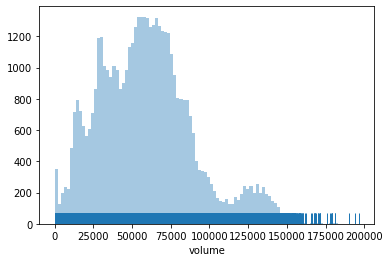

In [79]:
# filtering to less than 200,000 to keep useful scale.  values go all the way up to 690,083,600
sns.distplot(LCSdow[(LCSdow['volume'] < 200000) & (LCSdow['volume'] != 0)].volume, bins=100, rug=True, kde=False)

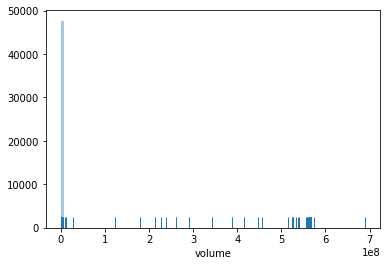

In [158]:
# what it looks like otherwise, 0 - 700,000,000
sns.distplot(LCSdow[(LCSdow['volume'] != 0)].volume, bins=100, rug=True, kde=False)

In [159]:
len(LCSdow[LCSdow['volume'] > 200000])

181

In [97]:
LCSdow.groupby('DetectorId').agg({'volume':'median'}).reset_index().sort_values('volume',ascending=False).head()

,DetectorId,volume
68,5085,138343.0
69,5086,138243.0
66,5083,138154.0
65,5082,132258.0
64,5081,131858.0


### Boxplots for every sensor
5199, 5302, 7901, 59997 have some very high outliers

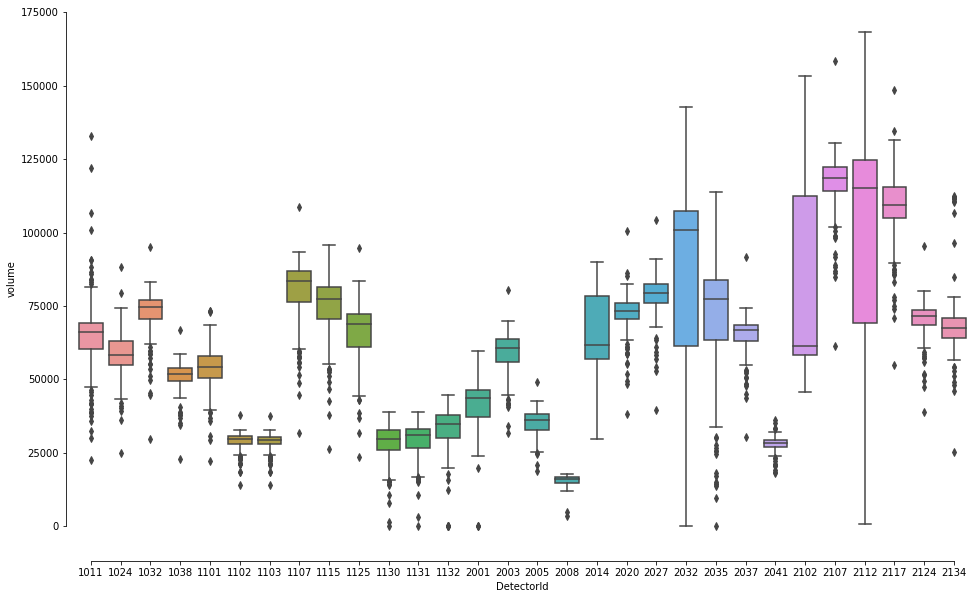

In [110]:
plt.figure(figsize=(16, 10))

sns.boxplot(x="DetectorId", y="volume",
            data=LCSdow[(LCSdow['DetectorId'].isin(idlist[0:30])) & (LCSdow['volume'] != 0) & (~LCSdow['date'].isin(lowdates))])
sns.despine(offset=10, trim=True)

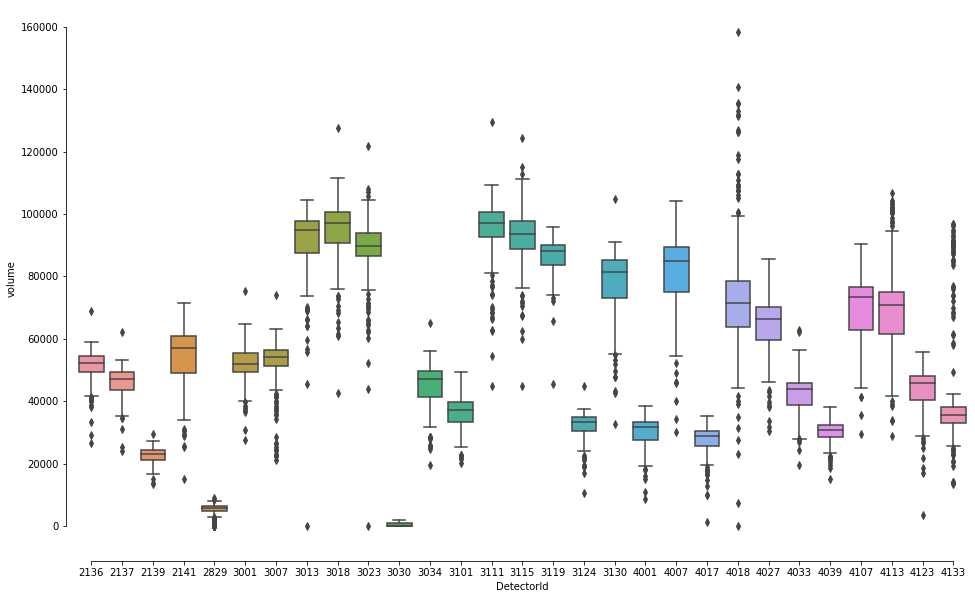

In [111]:
plt.figure(figsize=(16, 10))

sns.boxplot(x="DetectorId", y="volume",
            data=LCSdow[(LCSdow['DetectorId'].isin(idlist[31:60])) & (LCSdow['volume'] != 0) & (~LCSdow['date'].isin(lowdates))])
sns.despine(offset=10, trim=True)

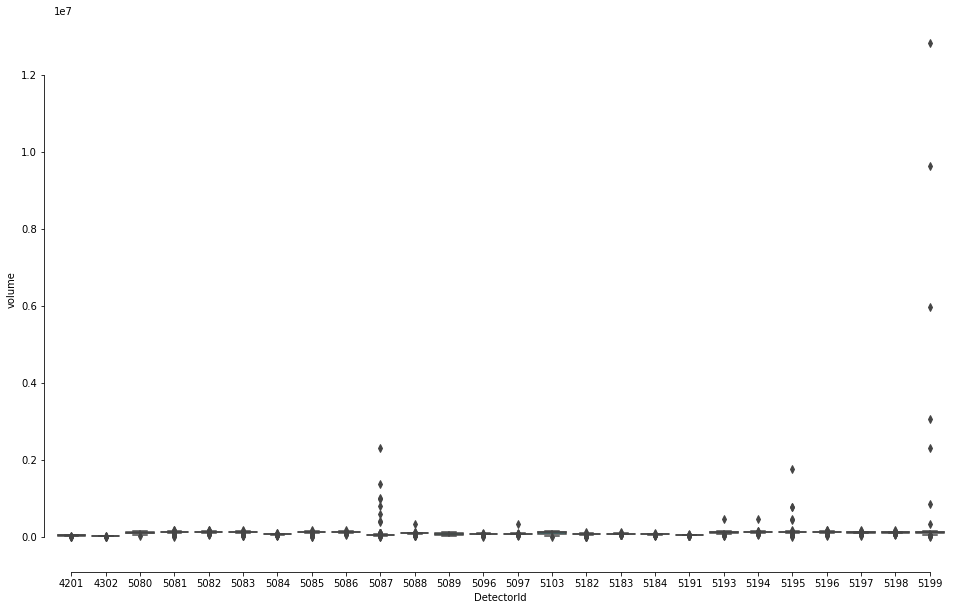

In [112]:
plt.figure(figsize=(16, 10))

sns.boxplot(x="DetectorId", y="volume",
            data=LCSdow[(LCSdow['DetectorId'].isin(idlist[61:90])) & (LCSdow['volume'] != 0) & (~LCSdow['date'].isin(lowdates))])
sns.despine(offset=10, trim=True)

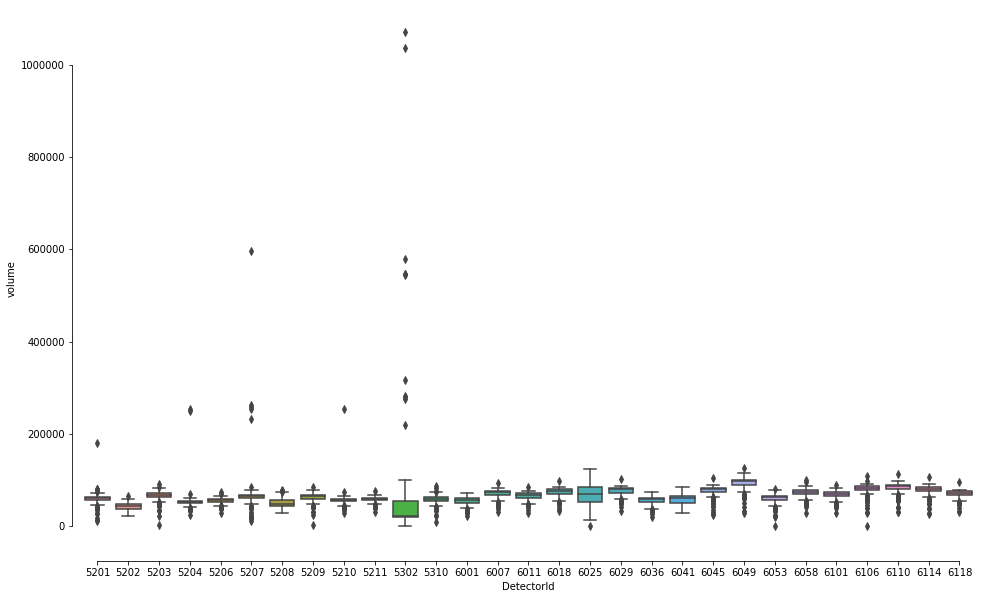

In [113]:
plt.figure(figsize=(16, 10))

sns.boxplot(x="DetectorId", y="volume",
            data=LCSdow[(LCSdow['DetectorId'].isin(idlist[91:120])) & (LCSdow['volume'] != 0) & (~LCSdow['date'].isin(lowdates))])
sns.despine(offset=10, trim=True)

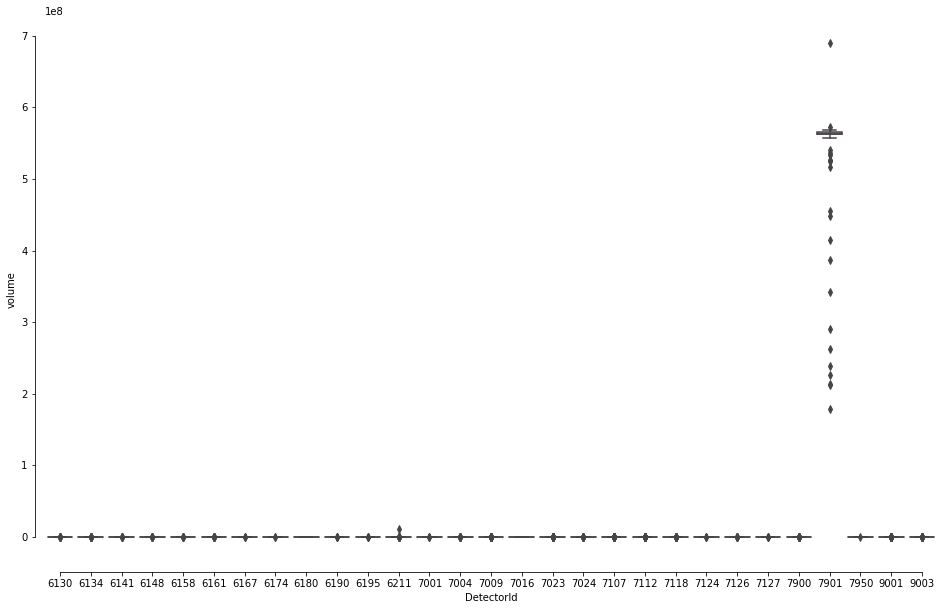

In [116]:
plt.figure(figsize=(16, 10))

sns.boxplot(x="DetectorId", y="volume",
            data=LCSdow[(LCSdow['DetectorId'].isin(idlist[121:150])) & (LCSdow['volume'] != 0) & (~LCSdow['date'].isin(lowdates))])
sns.despine(offset=10, trim=True)

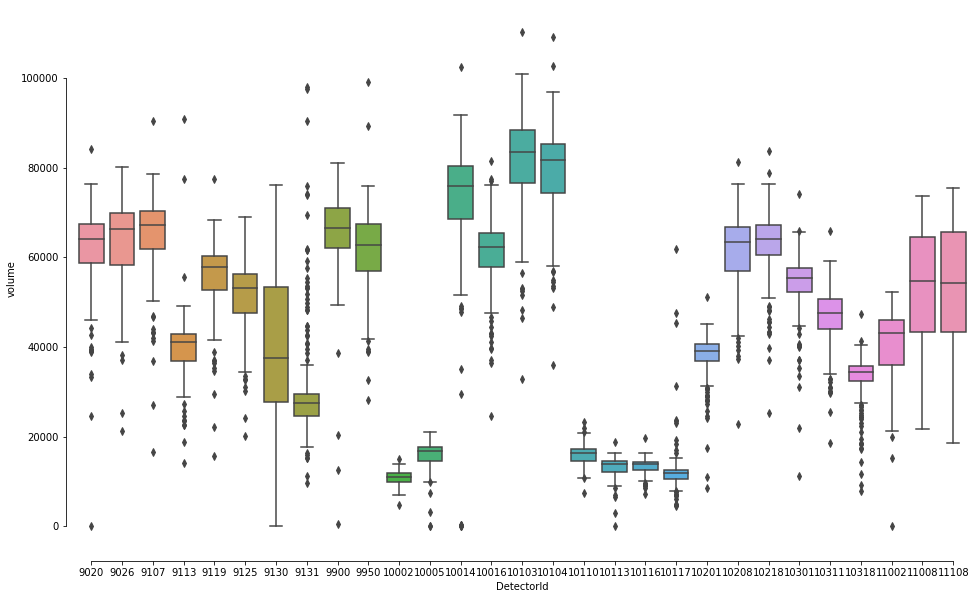

In [117]:
plt.figure(figsize=(16, 10))

sns.boxplot(x="DetectorId", y="volume",
            data=LCSdow[(LCSdow['DetectorId'].isin(idlist[151:180])) & (LCSdow['volume'] != 0) & (~LCSdow['date'].isin(lowdates))])
sns.despine(offset=10, trim=True)

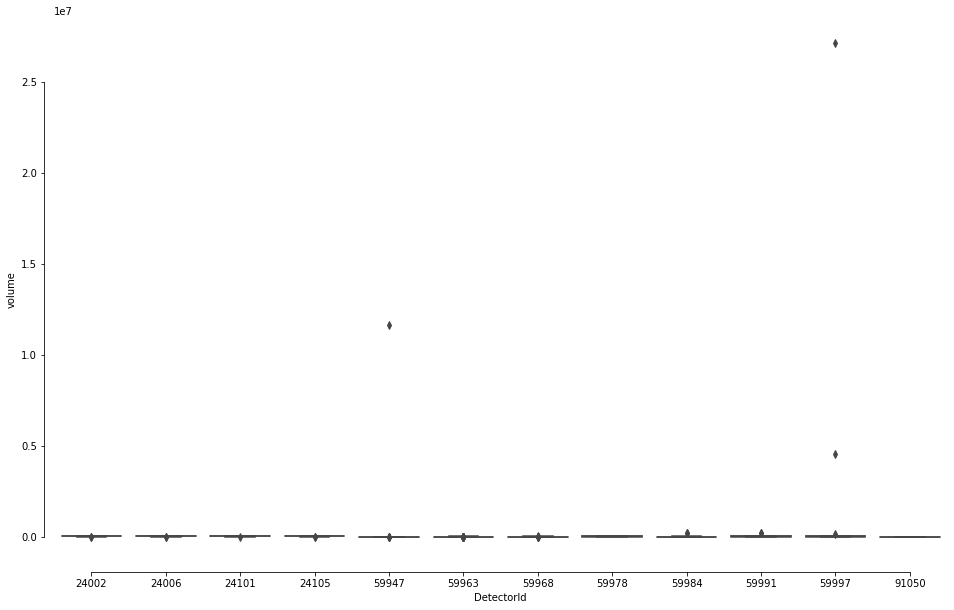

In [118]:
plt.figure(figsize=(16, 10))

sns.boxplot(x="DetectorId", y="volume",
            data=LCSdow[(LCSdow['DetectorId'].isin(idlist[181:210])) & (LCSdow['volume'] != 0) & (~LCSdow['date'].isin(lowdates))])
sns.despine(offset=10, trim=True)

### High Values
7901 dwarfs all the others

In [131]:
LCSdow[LCSdow['DetectorId'].isin([5199,5302,7901,59997])].sort_values('volume',ascending=False).head(10)

,date,dow,DetectorId,volume,DetectorId1
71650,2019-03-01,4,7901,690083550.0,5265
70015,2019-02-28,3,7901,573038040.0,4401
412769,2019-11-15,4,7901,568188450.0,4320
397883,2019-11-06,2,7901,568188450.0,4320
12649,2019-01-24,3,7901,566877750.0,4296
399537,2019-11-07,3,7901,566222400.0,4320
435925,2019-11-29,4,7901,566222400.0,4320
426001,2019-11-23,5,7901,566222400.0,4320
391267,2019-11-02,5,7901,566222400.0,4320
430963,2019-11-26,1,7901,566222400.0,4320


In [154]:
LCSdow['DetectorIdstring'] = LCSdow['DetectorId'].astype('str')

C:\Users\sbuchhorn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [175]:
# CHART - time series for the four high volume sensors (legend all the way to right)
# !note that dates are missing data altogether and the time interval between points is not always one day!

source = LCSdow[LCSdow['DetectorIdstring'].isin(['5199','5302','7901','59997'])]

base = alt.Chart(source)

mean = base.mark_line().encode(
    color=alt.Color('DetectorIdstring',scale=alt.Scale(domain=['5199', '5302', '7901', '59997'],
                                   range=['black','blue','green','gold'])),
    x='date',
    y='volume',
    tooltip=['date','volume','DetectorId']
).interactive()

render(mean)

In [156]:
# where?
df[df['detectorid2'] == 7901]

,Unnamed: 0,expressway,loc1,type1,id,direction,type2,location1,detectorid2,aadt,aadt18,aadt19
637,1132,BISHOP FORD,MICH,2LCS,01610094W51056,W,2LCS,MICH,7901.0,48400.0,0.0,523586900.0
